# Racing Analysis

In [248]:
from capo.load_datasets import get_tasks
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt

In [249]:
dataset = "sst-5"
optimizer = "CAPO"  # "EvoPromptGA" # CAPO
model = "llama"
seed = 42

In [250]:
task, _, _ = get_tasks(
    dataset_name=dataset,
    optimizer_name=optimizer,
    seed=seed,
    block_size=30,
)

init_prompts = task.initial_prompts;

Repo card metadata block was not found. Setting CardData to empty.
Repo card metadata block was not found. Setting CardData to empty.
C:\Users\schla\git\capo\capo\load_datasets.py:72: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\schla\git\capo\capo\load_datasets.py:75: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\schla\git\capo\capo\load_datasets.py:72: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

## Initial Prompts Analysis

In [251]:
path = glob(f"../results/racing_test/*/*/step_results.csv")[0]
df = pd.read_csv(path)

In [252]:
df["contains_init"] = df["prompt"].apply(lambda x: any([prompt in x for prompt in init_prompts]))

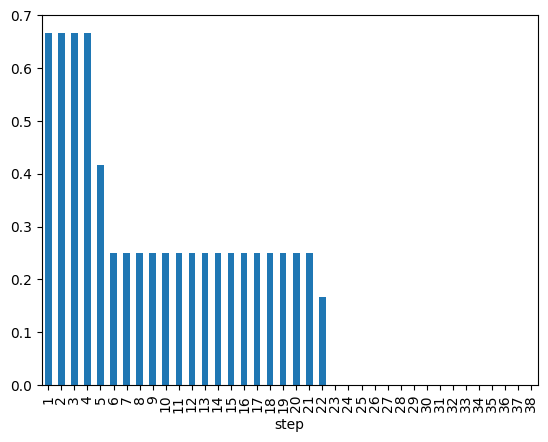

In [253]:
df.groupby("step").mean(numeric_only=True)["contains_init"].plot(kind="bar");

KeyError: 'Column not found: test_score'

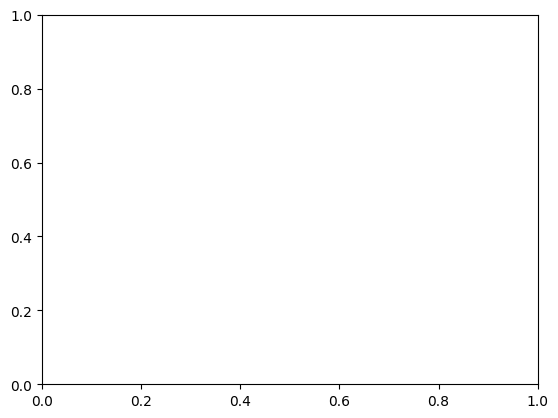

In [254]:
# boxplot
df.groupby("prompt").first().boxplot(column="test_score", by="contains_init");

In [ ]:
# get the init prompt that dominates
df[df["contains_init"]].groupby("prompt", as_index=False).mean(numeric_only=True)[
    ["prompt", "test_score"]
].sort_values("test_score", ascending=False)

,prompt,test_score
5,What sentiment does this movie review convey? ...,0.604
2,Movie review sentiment classification task: Fr...,0.600
0,Analyze the sentiment expressed in this film c...,0.598
1,"Given this movie critique, determine whether t...",0.584
3,Quick sentiment check - is this movie review v...,0.574
4,Read the movie review and identify its sentime...,0.574


## Prompt Survival Analysis

In [255]:
import plotly.express as px

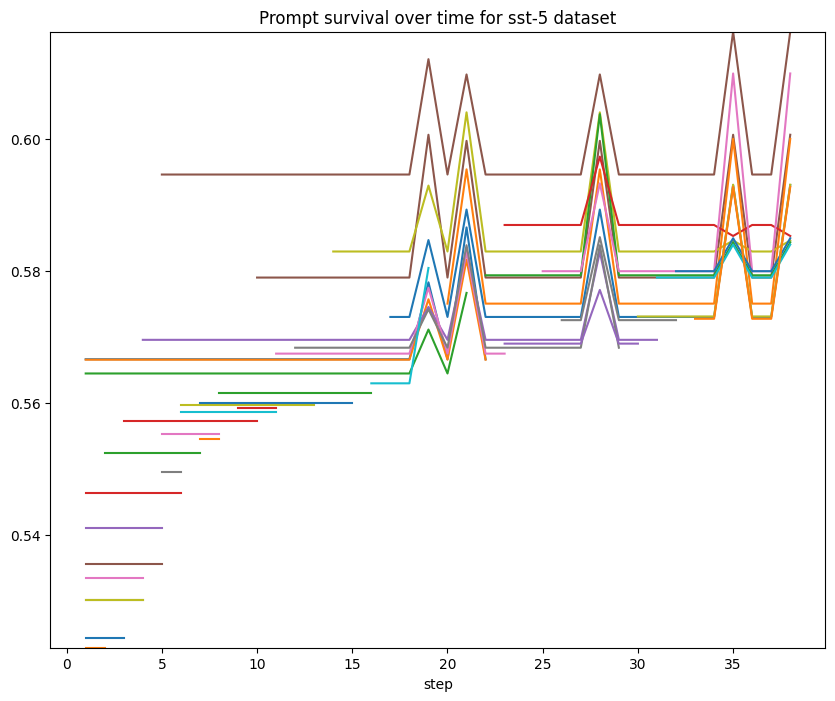

In [256]:
fig, ax = plt.subplots(figsize=(10, 8))
for prompt in df["prompt"].unique():
    df[df["prompt"] == prompt].plot(x="step", y="score", ax=ax)
ax.get_legend().remove()
ax.set_ylim(min(df["score"]), max(df["score"]))
ax.set_title(f"Prompt survival over time for {dataset} dataset")
plt.show()

## Block Score Analysis

In [257]:
df["prompt_short"] = df["prompt"].apply(lambda x: " ".join(x.split()[:20]))

In [258]:
path = glob(f"../results/racing_test/*/*/prompt_scores.csv")[0]
prompt_scores_df = pd.read_csv(path)
prompt_scores_df.rename(columns={"Unnamed: 0": "prompt"}, inplace=True)

In [259]:
# count how many columns have no missing values and add it as a column
prompt_scores_df["evaluated_blocks"] = 10 - prompt_scores_df.isnull().sum(axis=1)

In [260]:
blocks_df = prompt_scores_df[["prompt", "step", "evaluated_blocks"]]

In [261]:
prompt_scores_df

,prompt,0,1,2,3,4,5,6,7,8,9,step,evaluated_blocks
0,Analyze the given movie review to determine it...,0.666667,0.566667,0.633333,0.333333,0.400000,0.400000,0.700000,0.533333,0.700000,0.466667,0,10
1,Analyze the sentiment expressed in this film c...,0.733333,0.600000,0.633333,0.433333,0.533333,0.566667,0.533333,0.633333,0.633333,0.466667,0,10
2,"Assess the sentiment of a movie review, catego...",0.666667,0.633333,0.666667,0.433333,0.433333,0.400000,0.600000,0.533333,0.600000,0.400000,0,10
3,Assess the tone of the provided film review an...,0.633333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
4,Classify the sentiment in this cinema critique...,0.200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3366,"To determine the sentiment of a movie review, ...",0.733333,0.466667,0.666667,0.400000,0.566667,0.533333,0.633333,0.566667,0.566667,0.433333,37,10
3367,"To evaluate the sentiment of a movie review, d...",0.633333,0.533333,0.700000,0.433333,0.266667,NaN,NaN,NaN,NaN,NaN,37,5
3368,"To evaluate the sentiment of a movie review, d...",0.666667,0.600000,0.666667,0.400000,0.466667,0.433333,NaN,NaN,NaN,NaN,37,6
3369,"To evaluate the sentiment of a movie review, d...",0.766667,0.600000,0.666667,0.400000,0.533333,0.533333,0.600000,0.566667,0.600000,0.433333,37,10


In [262]:
df_with_blocks = df.merge(blocks_df, on=["prompt", "step"], how="left")
df_with_blocks

,step,timestamp,time_elapsed,score,prompt,input_tokens_meta_llm,output_tokens_meta_llm,input_tokens_downstream_llm,output_tokens_downstream_llm,contains_init,prompt_short,evaluated_blocks
0,1,2025-03-19 22:27:46.543906,1296.562003,0.566621,Review the text and decide which sentiment cat...,1445,566,1078871,123626,True,Review the text and decide which sentiment cat...,10.0
1,1,2025-03-19 22:27:46.543906,1296.562003,0.566552,Movie review sentiment classification task: Fr...,1445,566,1078871,123626,True,Movie review sentiment classification task: Fr...,10.0
2,1,2025-03-19 22:27:46.543906,1296.562003,0.564460,Analyze the sentiment expressed in this film c...,1445,566,1078871,123626,True,Analyze the sentiment expressed in this film c...,10.0
3,1,2025-03-19 22:27:46.543906,1296.562003,0.546322,Conduct an emotional tone evaluation of the pr...,1445,566,1078871,123626,False,Conduct an emotional tone evaluation of the pr...,10.0
4,1,2025-03-19 22:27:46.543906,1296.562003,0.541034,Evaluate the emotional content of the followin...,1445,566,1078871,123626,True,Evaluate the emotional content of the followin...,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...
451,38,2025-03-20 00:31:25.541749,113.987315,0.585322,"For a movie review, evaluate its emotional ton...",1712,735,36701,21913,False,"For a movie review, evaluate its emotional ton...",NaN
452,38,2025-03-20 00:31:25.541749,113.987315,0.584977,"For the purpose of sentiment analysis, evaluat...",1712,735,36701,21913,False,"For the purpose of sentiment analysis, evaluat...",NaN
453,38,2025-03-20 00:31:25.541749,113.987315,0.584632,Assess the sentiment of a movie review and ass...,1712,735,36701,21913,False,Assess the sentiment of a movie review and ass...,NaN
454,38,2025-03-20 00:31:25.541749,113.987315,0.584356,To determine the emotional tone conveyed in a ...,1712,735,36701,21913,False,To determine the emotional tone conveyed in a ...,NaN


In [263]:
# do the same with plotly
fig = px.line(
    df_with_blocks,
    x="step",
    y="score",
    color="prompt",
    custom_data=[df_with_blocks["prompt_short"], df_with_blocks["evaluated_blocks"]],
)
fig.update_xaxes(title="step")
fig.update_layout(title=f"Prompt survival over time for {dataset} dataset")

# # do not show the legend
fig.update_layout(showlegend=False, height=800)

# # show prompt_short instead of prompt in the hover
fig.update_traces(
    hovertemplate="prompt: %{customdata[0]}<br>score: %{y}<br>test score:%{customdata[2]}<br>evaluated blocks:%{customdata[1]}",
    name="",
)
fig.show()

In [266]:
# analyze what happened between step 18 and 19
step_18 = prompt_scores_df[prompt_scores_df["step"] == 18]
step_19 = prompt_scores_df[prompt_scores_df["step"] == 19]

In [301]:
# population in step 18 and 19
pop18 = list(df[df["step"] == 18]["prompt"])
pop19 = list(df[df["step"] == 19]["prompt"])

pops = pop18 + pop19
pops_unique = list(set(pops))

In [306]:
# count how many duplicates are in pop18 and pop19
pop18_count = {p: pops.count(p) for p in pops_unique}
pop19_count = {p: pops.count(p) for p in pops_unique}

pop18_count

{"Assess the sentiment of a given movie review and categorize it into one of five emotional tone categories - very negative, negative, neutral, positive, or very positive - based on the expressed opinion's intensity, and clearly denote your chosen category between <final_answer>answer</final_answer> for efficient classification and further assessment.\n\nInput:\nmay seriously impair your ability to ever again maintain a straight face while speaking to a highway patrolman .\nOutput:\n<final_answer>neutral</final_answer>\n\nInput:": 2,
 "Assess the sentiment of a movie review and assign it to one of five emotional categories: very negative, negative, neutral, positive, or very positive, then encapsulate your selected category within <final_answer> and </final_answer> markers for straightforward extraction and analysis, facilitating the identification of the review's sentiment for subsequent evaluation.\n\nInput:\nthe best thing that can be said of the picture is that it does have a few c

In [269]:
# check which prompts are new in step 19
new_prompts = step_19[~step_19["prompt"].isin(step_18["prompt"])]
new_prompts

,prompt,0,1,2,3,4,5,6,7,8,9,step,evaluated_blocks
1001,Assess the emotional undertones and opinion in...,0.566667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19,1
1005,Assess the sentiment of a given movie review b...,0.666667,0.533333,0.533333,0.500000,0.600000,0.533333,0.466667,0.700000,0.633333,0.433333,19,10
1010,"Assess the sentiment of a given movie review, ...",0.733333,0.566667,0.666667,0.466667,0.566667,0.566667,0.666667,0.566667,0.633333,0.400000,19,10
1054,"Evaluate the sentiment of a movie review, dete...",0.633333,0.533333,0.600000,0.466667,0.500000,0.500000,NaN,NaN,NaN,NaN,19,6
